# Titanic - Machine Learning from Disaster

## Imports

In [75]:
import opendatasets as od

In [76]:
import pandas as pd

In [220]:
import numpy as np

In [227]:
from scipy.stats import skew

In [78]:
import math

## 1. Getting the Data

In [79]:
!pip install opendatasets

In [80]:
od.download("https://www.kaggle.com/competitions/titanic/data")


Skipping, found downloaded files in ".\titanic" (use force=True to force download)


Here is our training set:

In [81]:
train_set = pd.read_csv('titanic/train.csv')

And here is our test set:

In [82]:
test_set = pd.read_csv('titanic/test.csv')

Below is a set of data in which survival predictions are made on gender. This should amount to something like a 50% survival rate.

In [83]:
survived = pd.read_csv('titanic/gender_submission.csv')

Let's take a quick look at the data to make sure it is all good:

In [84]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Looks thick, solid and tight. How many rows are there in the sets?

In [85]:
print('Number of rows in training set: ' + str(len(train_set)))
print('Number of rows in test set:     ' + str(len(test_set)))

Number of rows in training set: 891
Number of rows in test set:     418


Perhaps not the ideal 80/20 split, but oh well. Now it's time for our second step - studying the data more in depth!

## 2. Studying and Cleaning the Data

### Missing data

First of all, let's take a look at how many rows are null values!

In [86]:
print('EMPTY ROWS:\n')

for category in train_set:
    null_values = len(np.where(pd.isnull(train_set[category]))[0])
    print(category +  ": " + str(null_values) + ", " + str(math.ceil(null_values/len(train_set) * 100)) + '%')

EMPTY ROWS:

PassengerId: 0, 0%
Survived: 0, 0%
Pclass: 0, 0%
Name: 0, 0%
Sex: 0, 0%
Age: 177, 20%
SibSp: 0, 0%
Parch: 0, 0%
Ticket: 0, 0%
Fare: 0, 0%
Cabin: 687, 78%
Embarked: 2, 1%


In [87]:
#TODO: Try making this a DataFrame instead

Seems like there are three rows that need some action; 'Age', 'Cabin' and 'Embarked'.

'Age' has a medium amount of missing values, 'Cabin' is largely missing altogether, while 'Embarked' is mostly filled out. These will all be handled in section 3.

## 3. Preprocessing the data

#### Handling missing data

First we'll deal with the missing data, and we'll start with 'Age'. 

In [88]:
print(train_set['Age'][:20])

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5      NaN
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17     NaN
18    31.0
19     NaN
Name: Age, dtype: float64


It can safely be assumed that the age of an individual affects survival rate, so we would like to keep this category. That means we'll have to fill it out, with either the mean, median or mode value. Let's check out what they are!

First we'll make a copy of the training set without any missing age values:

In [192]:
train_set_without_missing_age_values = train_set.dropna(subset=['Age'])

##### Mean

In [216]:
no_of_passengers = len(train_set_without_missing_age_values)
sum_of_ages = train_set_without_missing_age_values['Age'].sum()
mean_age = sum_of_ages / no_of_passengers

print('Mean passenger age: ' + str(round(mean_age, 1)) + " years")

Mean passenger age: 29.7 years


##### Median

In [217]:
train_set_by_age = train_set_without_missing_age_values.sort_values(by=['Age'])
no_of_passengers = len(train_set_by_age)
median_age = train_set_by_age['Age'].iloc[math.ceil(no_of_passengers/2)]

print('Median passenger age: ' + str(round(median_age, 1)) + " years")

Median passenger age: 28.0 years


##### Mode

In [218]:
from collections import Counter

no_of_passengers = len(train_set_without_missing_age_values)
value = Counter(train_set_without_missing_age_values['Age'].apply(np.ceil))
findMode = dict(value)
mode_age = [i for i, v in findMode.items() if v == max(list(value.values()))]  

print("Mode passenger age: " + ', '.join(map(str, mode_age)))

Mode passenger age: 24.0


So there is a a difference in ~6 years between the lowest and highest "averages". Which should we choose?

<AxesSubplot:ylabel='Density'>

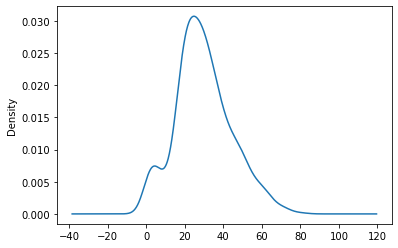

In [212]:
train_set_without_missing_age_values.Age.plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

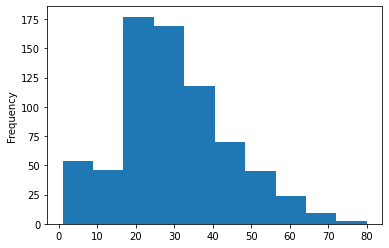

In [213]:
train_set_without_missing_age_values.Age.plot(kind='hist')

In [230]:
print('Skew: ' + str(skew(train_set_without_missing_age_values['Age'])))

Skew: 0.3897163766246446


Seeing as our data is slightly skewed, we will fill missing age values with the median age.

(Source: https://statisticsbyjim.com/basics/measures-central-tendency-mean-median-mode/)

In [255]:
train_set_median = train_set 
train_set_median['Age'] = train_set['Age'].fillna(median_age)

Let's make sure we didn't screw this up.

In [254]:
train_set_median.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
